# Air passengers data: Time Series Analysis
**Student:** Aissat Imane S1G1


### **Abstract**

This notebook analyzes the monthly number of airline passengers to identify trends and forecast future patterns. Through seasonal variations and long-term trends, the analysis aims at establishing the root causes of the passenger numbers and find potential future trends. The data is in the form of monthly observations and hence lends itself very well to trend analysis and forecasting. The findings of this study can result in a better understanding of historical air travel patterns and help contribute to refining forecasting methods for predicting future demand.


### **Introduction**


Data source: https://www.kaggle.com/datasets/rakannimer/air-passengers

Traveling and taking flights has expanded significantly over the years, increasing from a higher-class form of travel to a major aspect of connectivity that is accessible to anyone and everyone. The review of past traffic pattern in airlines assists us in defining parameters that affect airline demand. This allows us to identify trends using historical data about past traffic patterns and assist travel airlines for the future.

This study is based on a historical data set that records the monthly number of airline passengers from January 1949 to December 1960. The data, provides a time series of the numbers of passengers over these years, monthly, giving useful insight into long-term trends and regular fluctuations in the demand for air travel. From the analysis of this data set, we want to identify important trends, seasonal cycles, and potential influencing factors for changes in the numbers of passengers.

This analysis is important because air travel in the mid-20th century experienced expansion due to the advancement in technology and economic forces that increased the numbers of travelers. This historical pattern can also serve as an foundation for existing forecasting techniques to more accurately forecast demand in the future. The information gained from this study can have application within many fields, from economic studies to airline firm planning and business strategy development.



### **Libraries**

In [ ]:
install.packages('TSA')
install.packages('forecast')
install.packages('astsa')
install.packages('MASS')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
library(MASS)

## FIRST STEP: Plotting the data

1. First, we load the dataset.

In [ ]:
airtraffic = read.csv("AirPassengers.csv", header = TRUE, sep = ",")

In [ ]:
print(airtraffic)

      Month Passengers
1   1949-01        112
2   1949-02        118
3   1949-03        132
4   1949-04        129
5   1949-05        121
6   1949-06        135
7   1949-07        148
8   1949-08        148
9   1949-09        136
10  1949-10        119
11  1949-11        104
12  1949-12        118
13  1950-01        115
14  1950-02        126
15  1950-03        141
16  1950-04        135
17  1950-05        125
18  1950-06        149
19  1950-07        170
20  1950-08        170
21  1950-09        158
22  1950-10        133
23  1950-11        114
24  1950-12        140
25  1951-01        145
26  1951-02        150
27  1951-03        178
28  1951-04        163
29  1951-05        172
30  1951-06        178
31  1951-07        199
32  1951-08        199
33  1951-09        184
34  1951-10        162
35  1951-11        146
36  1951-12        166
37  1952-01        171
38  1952-02        180
39  1952-03        193
40  1952-04        181
41  1952-05        183
42  1952-06        218
43  1952-07

2. Plot the data.

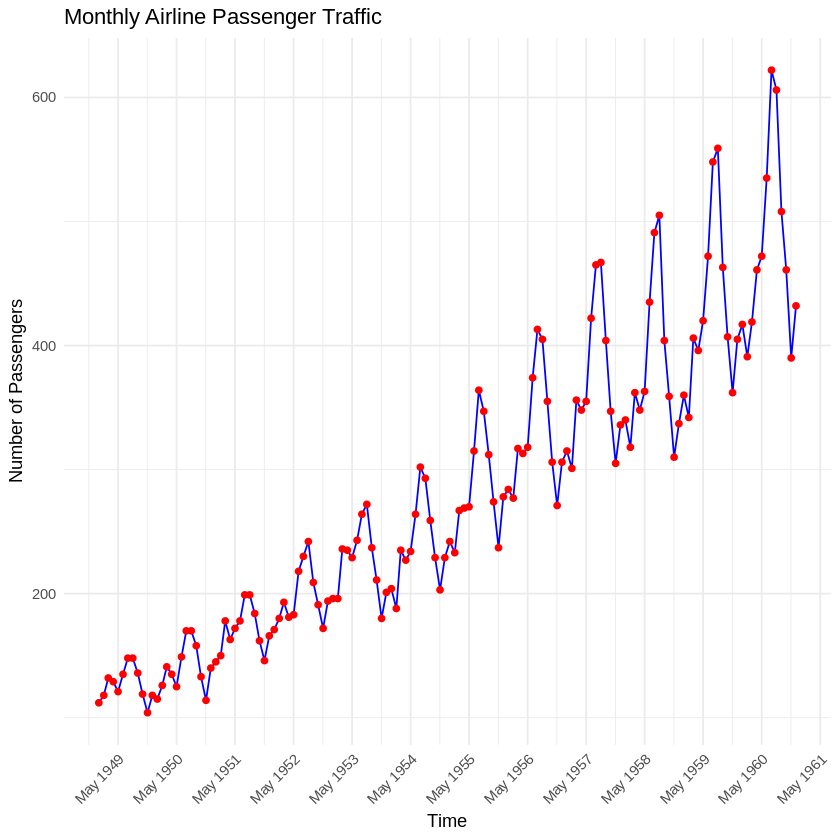

In [ ]:
library(ggplot2)

airtraffic$Month <- as.character(airtraffic$Month)

# converting the month to Date format
airtraffic$Month <- as.Date(paste0(airtraffic$Month, "-01"), format = "%Y-%m-%d")

ggplot(airtraffic, aes(x = Month, y = Passengers)) +
  geom_line(color = "blue") +
  geom_point(color = "red") +
  scale_x_date(date_labels = "%b %Y", date_breaks = "12 months") +
  labs(title = "Monthly Airline Passenger Traffic", x = "Time", y = "Number of Passengers") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))


From the plot we can observe:


*   There seems to be a linear upward trend to the data as the number of passengers seems to grow bigger over time.
*   Due to the clear upward trend, the mean does not seem to be constant. Same for the variance.
*   A seasonal pattern is evident, with the same trend repeating every 12 months, the number of passengers rises and falls in a consistent pattern every year:
  * Each year, the highest number of passengers is recorded in June, July, and August, which aligns with summer holidays when people tend to travel more.
  * The lowest number of passengers is observed in November and February, likely due to the winter season, when colder weather discourages travel and most people are engaged in their studies.



> Since the variance does not seem to be constant, our time series does not seem to be stationary so we should start by fixing that first.

There are many techniques that could be used to try and achieve stationarity:


1. **Variance Stablization:** Ensure stationarity by making the fluctuations in the data more uniform over time, to make it easier to capture trends without being affected by the variance changing over time.
2. **Differencing:** help stabilize the mean of a time series and therefore reducing trend and seasonality.

## SECOND STEP: Pre-processing of the data

1. Stabilization of the variance.
  * Since the variance seems to be increasing over time, we apply Box Cox transformation to lessen the impact of this non-constant variance to try and achieve stationarity.

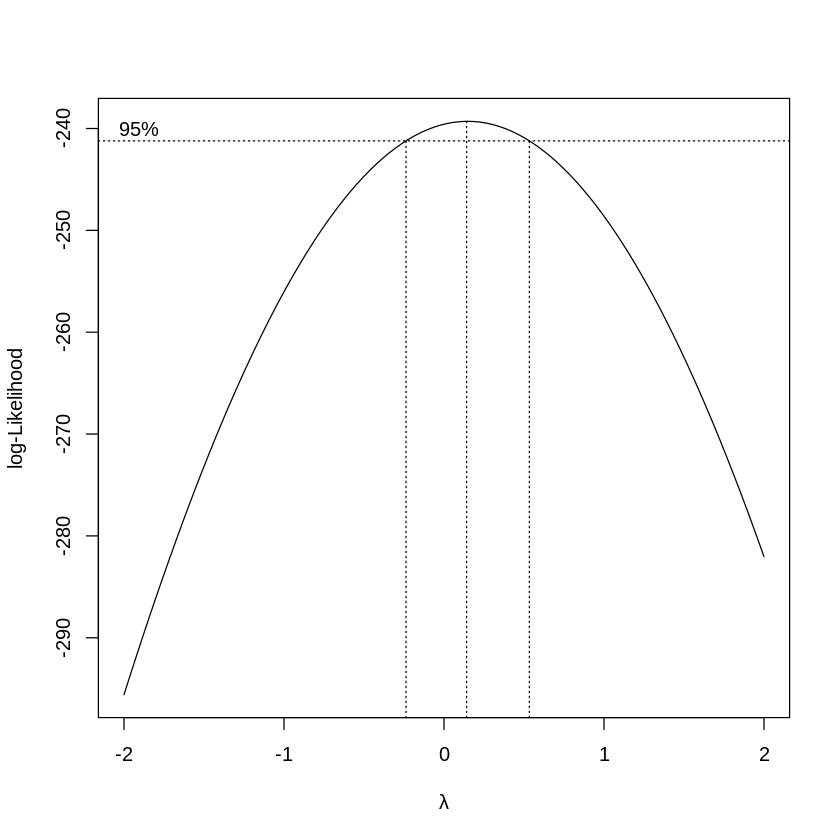

In [ ]:
model <- lm(Passengers  ~ 1, data = airtraffic)
boxcox(model, lambda = seq(-2, 2, 0.1))

From the log-likelihood plot of the Box-Cox transformation, we observe that the confidence interval for the transformation parameter
𝜆
λ is approximately
[−0.8 , 0.5]. The estimated optimal
𝜆
 is around 0.1, which is quite close to 0.

Since
𝜆
=
0
corresponds to the natural logarithm transformation (
𝑥
→
log
⁡
(
𝑥
)) , we choose
𝜆
=
0
to simplify the inverse transformation when forecasting.

Now, we apply the transformation

In [ ]:
airtrafficTransformed <- log(airtraffic$Passengers)

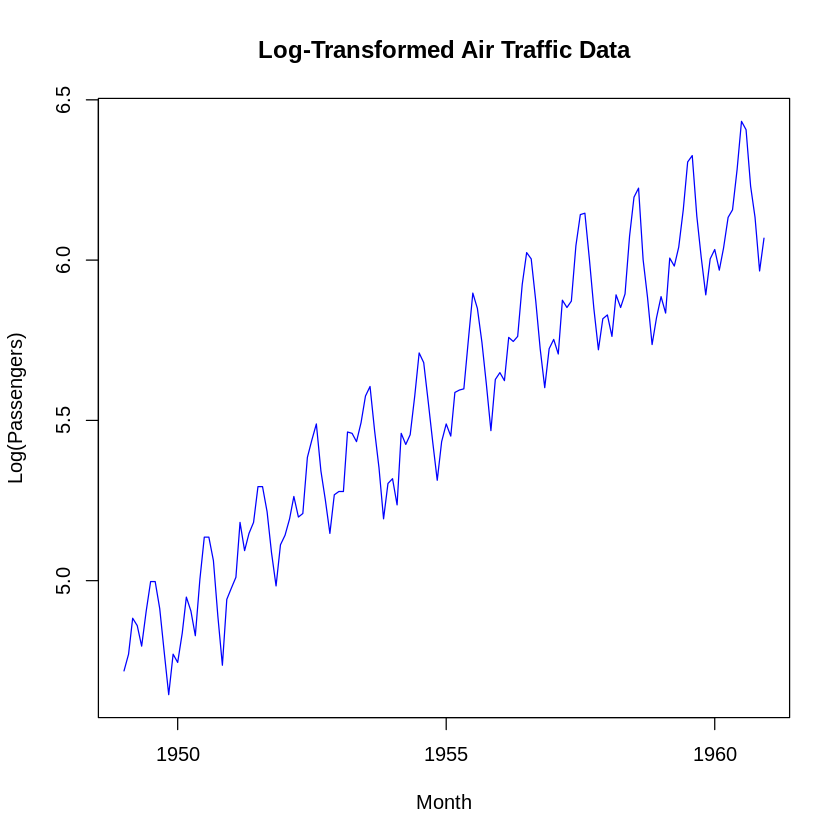

In [ ]:
plot(airtraffic$Month, airtrafficTransformed, type = "l", col = "blue",
     xlab = "Month", ylab = "Log(Passengers)",
     main = "Log-Transformed Air Traffic Data")

We can observe a noticeable difference between the plot before and after variance stabilization.
Before applying stabilization, the variance increased significantly around the years 1953–1955, showing a clear upward trend. However, after applying the log transform of the data, the fluctuations seem to be quite similar and uniform  across all years. Therefore, the impact of varying variance was effectively reduced, making the series more stable.

#### Split the data into train and test data

In [ ]:
split_index <- floor(0.9 * length(airtrafficTransformed))
airtrafficTrain <- airtrafficTransformed[1:split_index]
airtrafficTest <- airtrafficTransformed[(split_index + 1):length(airtrafficTransformed)]

### Plotting the ACF and PACF of the data

#### 1. ACF

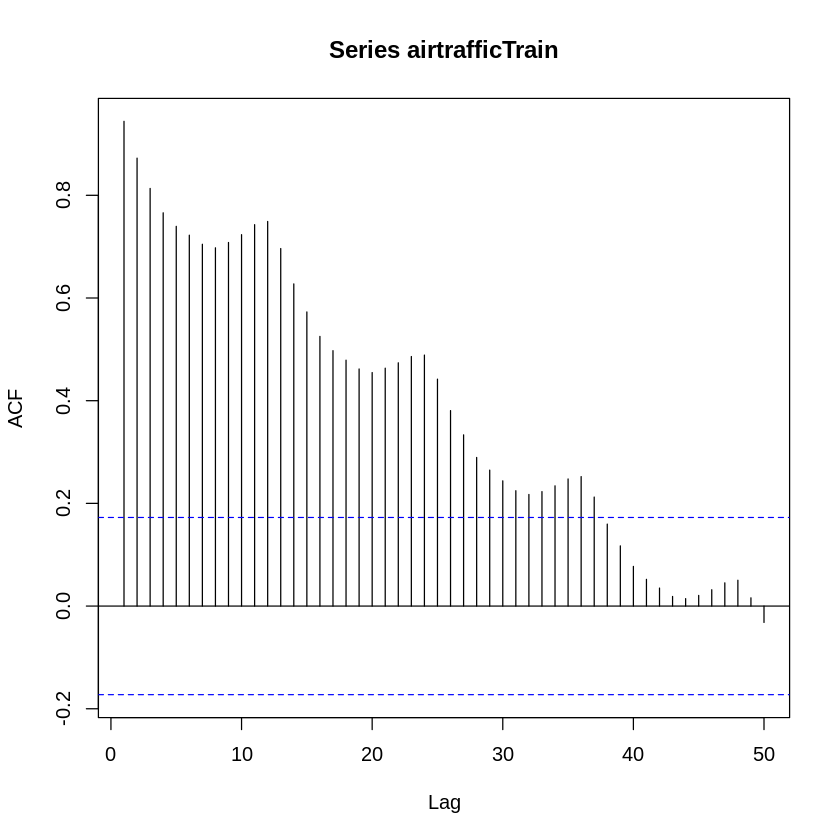

In [ ]:
acf(airtrafficTrain , lag.max = 50)

From the ACF of the data we can observe:
* The ACF plot shows that all lags have significant correlations, meaning the time series is not stationary and that differencing is probably needed.
* The ACF is decaying instead of cutting off which is a sign of the presence of an AR component.


#### 2. PACF

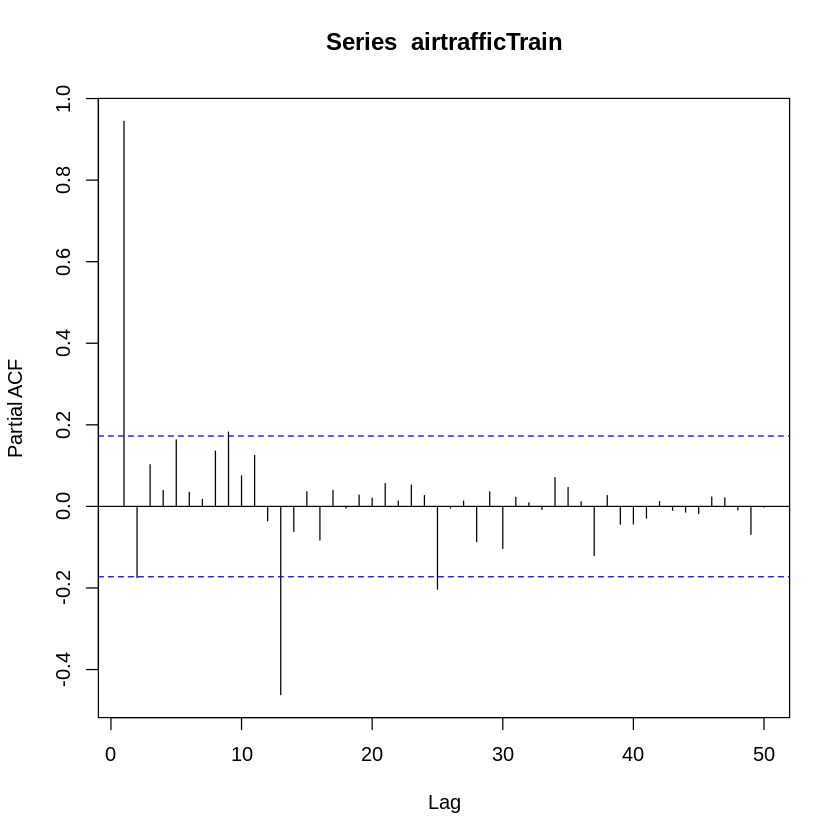

In [ ]:
pacf(airtrafficTrain , lag.max = 50)

From the plot of the PACF we can observe:
* The PACF plot shows a significant spike at lag 1.
* Most of the lag points are inside the confidence interval except for the lag 12 and lag 24 which is due to the seasonality of the data.
* The PACF doesn't cut off nor decays exponentially in a clear way which could be a sign of the presence of both the AR and MA components.

> **We can not determine anything from the ACF and the PACF given that our data is not yet stationary.**

## THIRD STEP: Differencing


Since our data seems to be non-stationary and shows strong seasonality with a period of 12, we will apply seasonal differencing to our train data in order to remove seasonality and reach stationarity.

In [ ]:
airtraffictwelvth <- diff(airtrafficTrain, differences = 12)

We plot our differenced data to get an idea

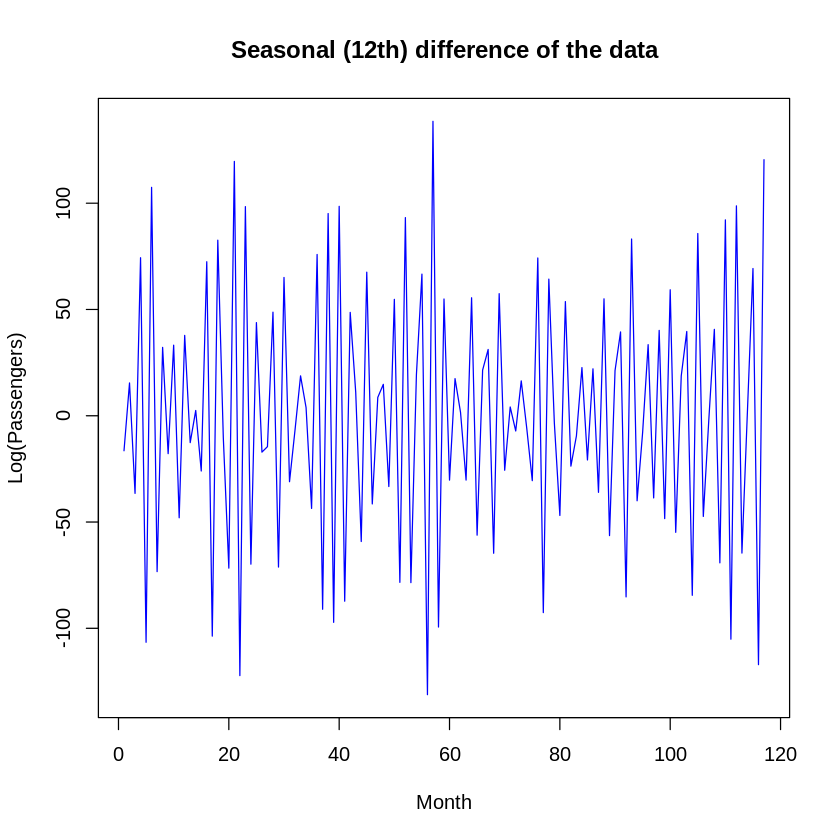

In [ ]:
plot(time(airtraffictwelvth), airtraffictwelvth, type = "l", col = "blue",
     xlab = "Month", ylab = "Log(Passengers)",
     main = "Seasonal (12th) difference of the data")

From the plot of our seasonally differenced data we can see some improvement when it comes to the upward trend and seasonality;
* The seasonality seems removed, but the fluctuations of the data points still seem strong and irregular and kind of instable. So we need to refer to our ACF and PACF to know if further differencing is needed or not.


#### 1. ACF of the 12th difference

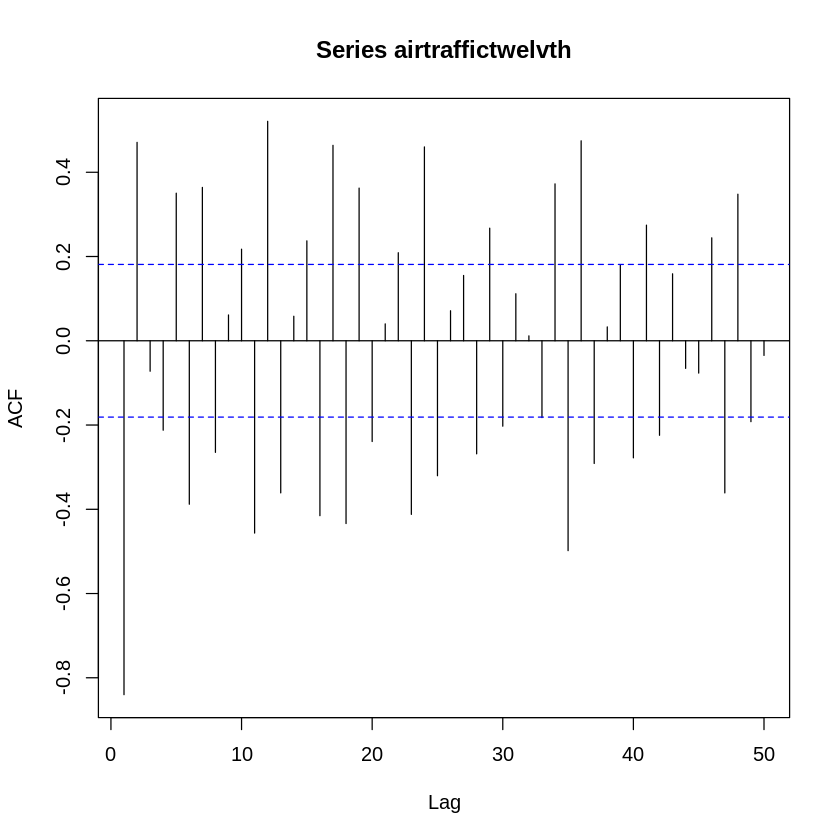

In [ ]:
acf(airtraffictwelvth, lag.max = 50)

> The ACF of the differenced data shows lots of spikes outside the confidence interval, which shows that our data points are highly correlated and therefore stationarity is not yet achieved and further differencing is likely needed.

We will refer to the PACF to confirm that.

#### 2. PACF of the 12th difference

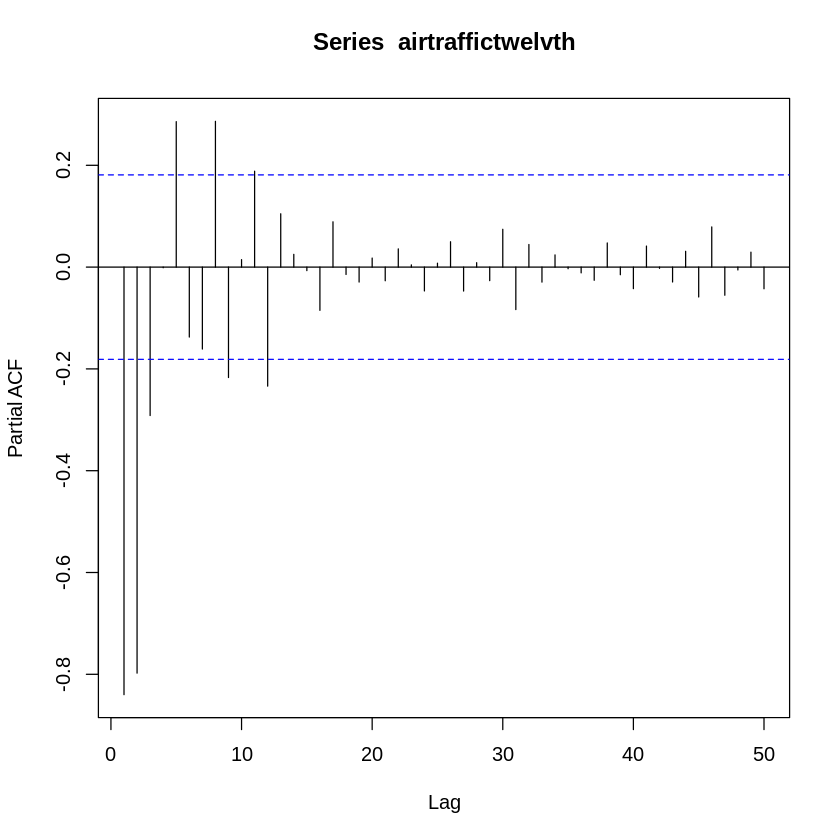

In [ ]:
pacf(airtraffictwelvth , lag.max = 50)

> The PACF of the differenced data shows high spikes outside the confidence interval at low lags until approximately the lag 12, which shows that some auto correlation is still present bewteen our data and that stationarity is not fully achieved yet.

We also notice a gradual decay of the PACF instead of a cutoff which suggests an AR component.

> We will perform a first order differencing and see if we reached stationarity or not yet.

### First differencing of the 12th difference

Now we perform the 1st difference on the 12th difference air transformed data

In [ ]:
airtraffictwelvthFirst <- diff(airtraffictwelvth, differences = 1)

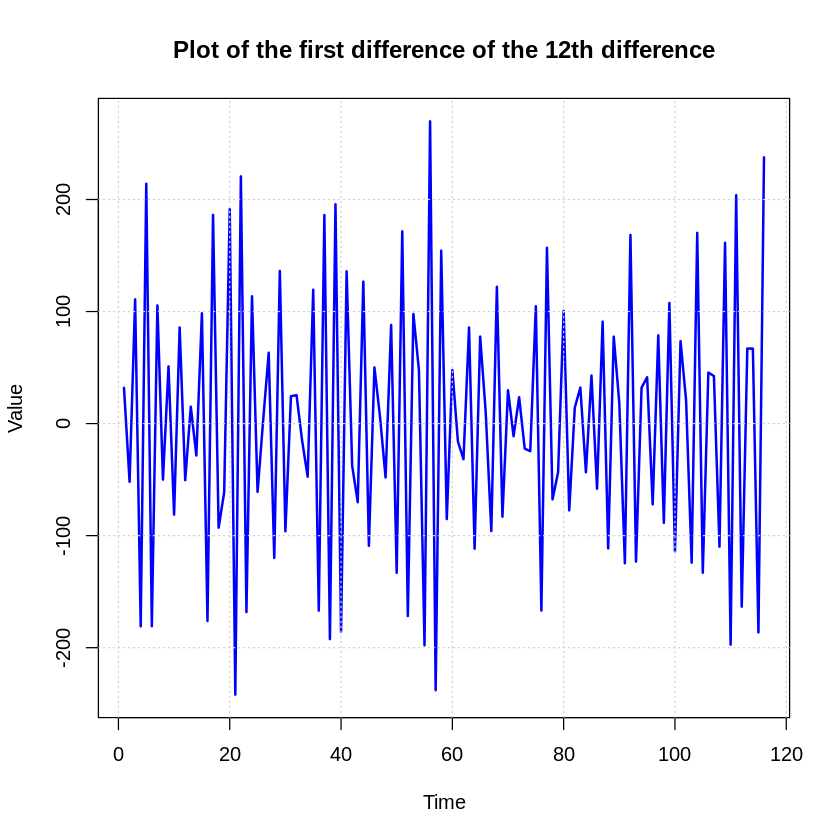

In [ ]:
plot(airtraffictwelvthFirst, type = "l", col = "blue", lwd = 2,
     main = "Plot of the first difference of the 12th difference",
     xlab = "Time", ylab = "Value")
grid()


Our time series is more likely stationary than before as we can see that we successfully got rid of:
* **The trend:** No strong upward movement is present.
* **Mean seems to be constant:** The series is oscillating around a constant mean which seems to be around 0.
* **Constant variance:** The fluctuations appear more stable across time than before.

#### 1. ACF of the 1st and 12th difference

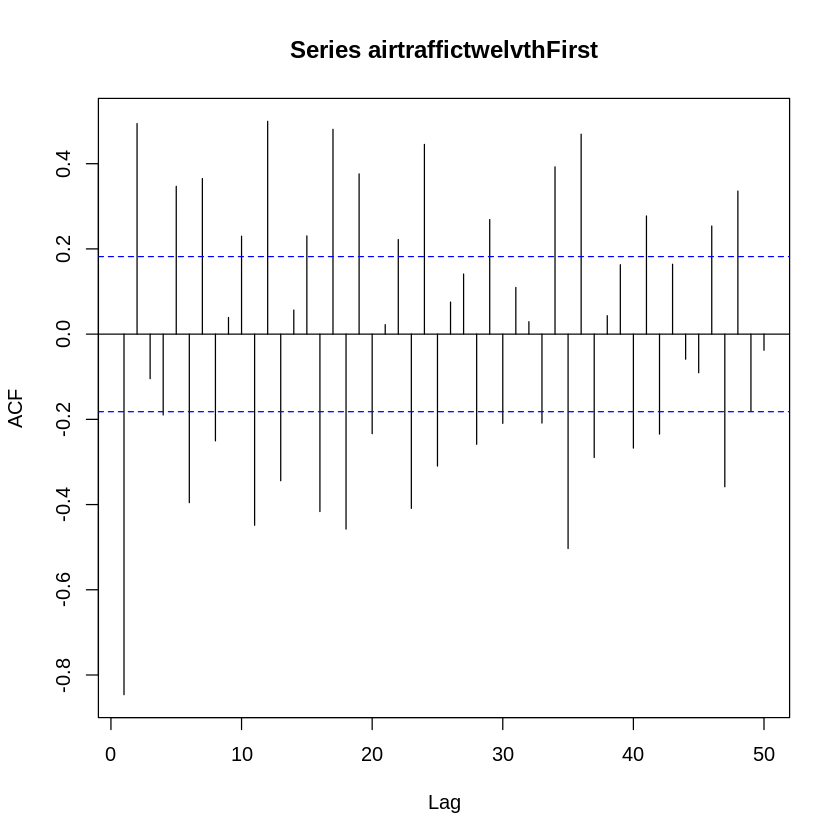

In [ ]:
acf(airtraffictwelvthFirst, lag.max = 50)

#### 2. PACF of the 1st and 12th difference

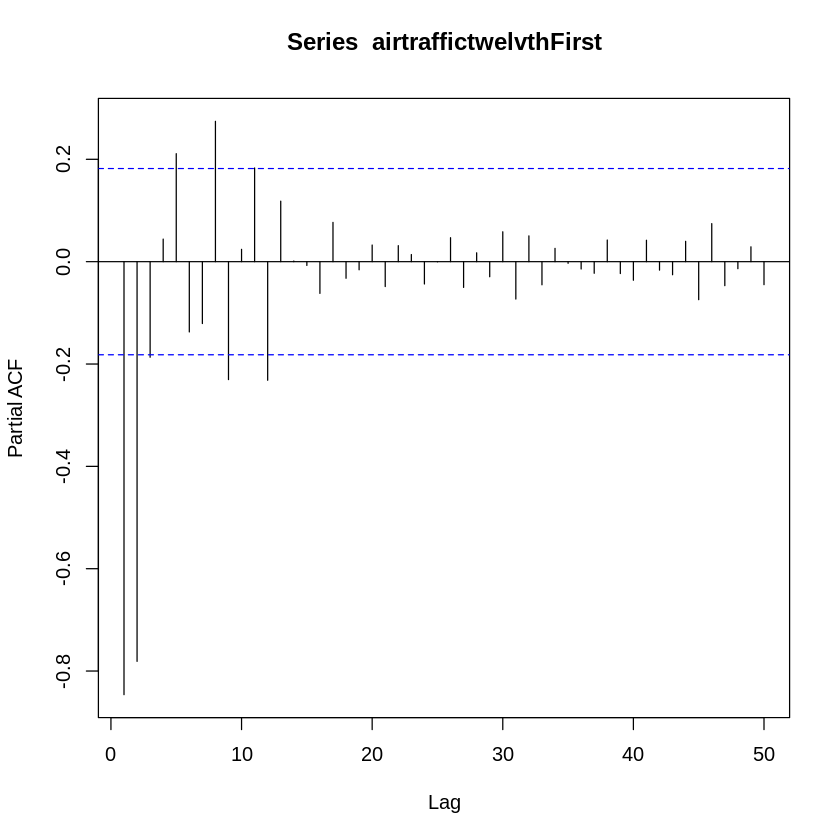

In [ ]:
pacf(airtraffictwelvthFirst, lag.max = 50)

But once again the auto correlation between the points of our series is quite present as it can be seen in our ACF and PACF which suggests that a second order differencing may be needed so we will try that and see.

### Second order differencing

In [ ]:
airtraffictwelvthSecond <- diff(airtraffictwelvthFirst, differences = 1)

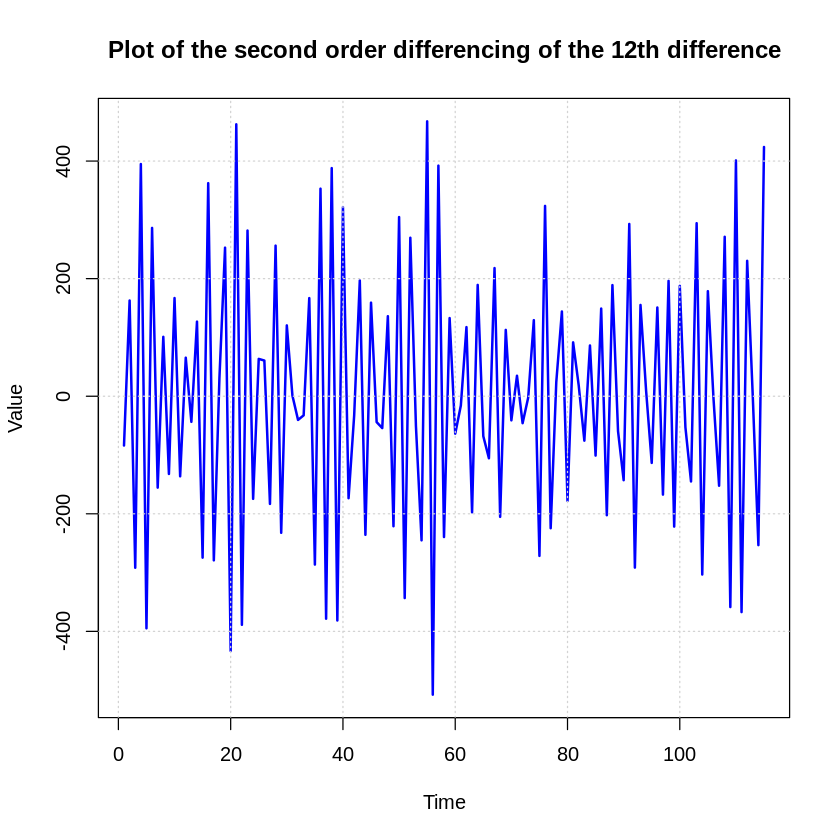

In [ ]:
plot(airtraffictwelvthSecond, type = "l", col = "blue", lwd = 2,
     main = "Plot of the second order differencing of the 12th difference",
     xlab = "Time", ylab = "Value")
grid()


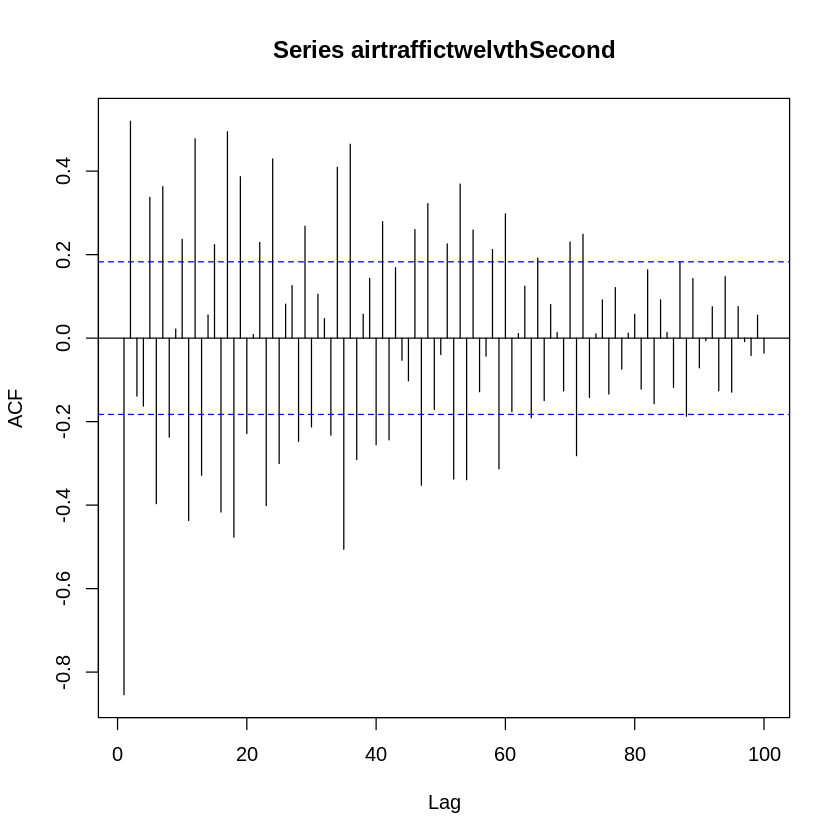

In [ ]:
acf(airtraffictwelvthSecond, lag.max = 100)

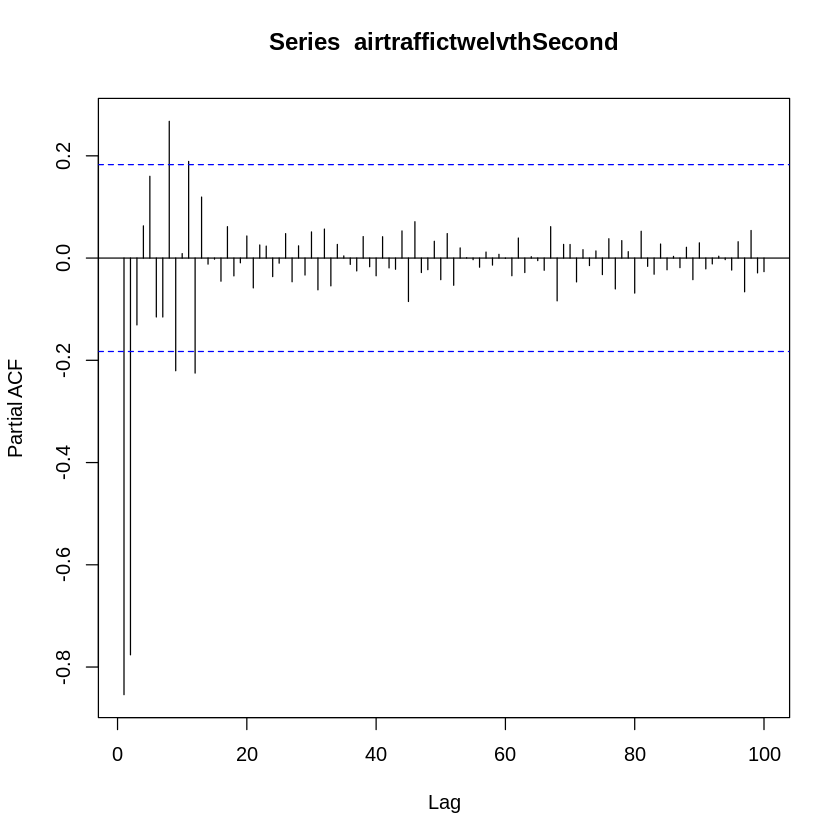

In [ ]:
pacf(airtraffictwelvthSecond, lag.max = 100)

Even after applying a second differencing to our time series, there doesn't seem to be any change when it comes to our ACF and PACF so we will work with the first difference.
> the ACF still shows a correlation between the data even if it was reduced, it has not completely disappeared after the first difference.
> The PACF in the other hand shows a faster decay than previously seen when the seasonal difference was applied alone, now it sharply descreases after the second lag and most of the lags are inside the confidence interval except for some of them like lag 8 and 9 which can be overlooked.

Overall we can say that our data is quite stationary after applying the seasonal difference and the first order difference.

We will verify that by applying the Augmented Dicky Fuller test.

#### **Augmented Dicky-Fuller test**

We will apply dicky fuller's test to check for the stationarity of the model after differencing.

**About the ADF test:**
It is a statistical test that helps check stationarity of a time series.
* The null hypothesis of the ADF test is: Time series is *not* stationary.
* The alternative hypothesis is: Time series is stationary.
  - If the p-value is < 0.05, we reject the null hypothesis (i.e., data is stationary).
  - If the p-value is > 0.05, the data is non-stationary.


In [ ]:
library(tseries)
adf.test(airtraffictwelvthFirst)

Warning message in adf.test(airtraffictwelvthFirst):
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  airtraffictwelvthFirst
Dickey-Fuller = -34.633, Lag order = 4, p-value = 0.01
alternative hypothesis: stationary


After applying Dicky Fuller's Stationarity test we have that:
* Our serie is stationary since we got a p-value of 0.01 which is less than the threshold 0.05 which means we reject H0.
  * and since in Dicky Fuller's test H0 is : the serie is not stationary, rejecting it implies that we accept H1: the serie is stationary.

Since the serie is stationary then we can use the tools like the ACF plot, PACF and the BIC to determine our candidate models.

## FOURTH STEP: Determining candidate models

we draw the ACF and PACF plots of the 12th and 1st difference combined to get insights about the candidate models

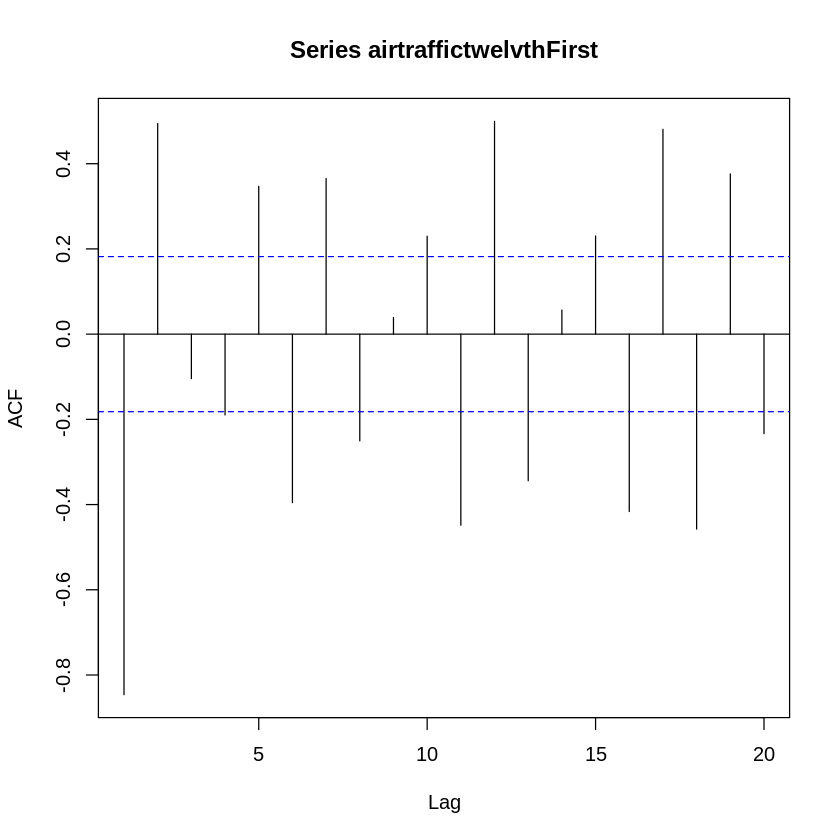

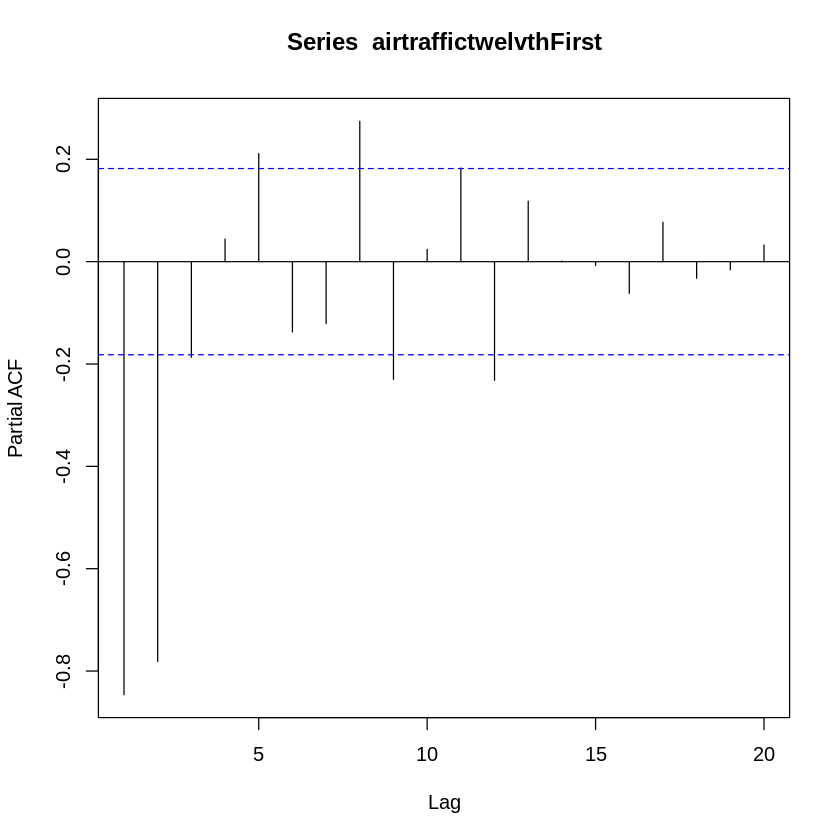

In [ ]:
acf(airtraffictwelvthFirst)
pacf(airtraffictwelvthFirst)

**From the ACF**
* The ACF shows a slow decay, indicating the presence of an AR component.
* There are some significant spikes, but they do not cut off completely at a certain lag, they rather continue fluctuating.

**From the PACF**
* The PACF has a sharp cutoff after lag 2, suggesting the presence of an AR (Auto-Regressive) component.
* The first few lags are significant, and then it gradually dies off.

From both the ACF and the PACF we can notice that our candidate models will contain those parts:

#### **for the AR component:**
As said before, the ACF doesn't show a sharp cut off but rather a decay and fluctuations which are signs of the presence of an AR component:

* **AR(2):** if we choose to ignore the significant lags after lag 2 in the PACF since the PACF sharply dies off after lag 2.
* **AR(5):** since there is a significant spike at lag 5 that we can choose to take into consideration.
*  **AR(8):** there is a signifcant spike at lag 8, even bigger than the lag 5 so we can consider it as well.

#### **for the MA component:**
* **MA(0):** because all spikes are outside the confidence interval, the ACF does not cut off so it could mean the absence of the MA component.
* **MA(1):** The ACF decays significantly after lag 1 compared to next lags.
* **MA(2):** The ACF is very small at lag 3 compared to lag 1 and 2 so we can try with q = 2.

The candidates models are all combinaisons with the 2 components like AR(8), ARMA(8,1), ARMA(5,2)...

> We will combine our findings with the Bayesian Information Criterion to determine our candidate models.

#### **Using the Bayesian Information criterion**

Warning message in ar.ols(x, aic = aic, order.max = order.max, na.action = na.action, :
“model order:  16 singularities in the computation of the projection matrix results are only valid up to model order 15”


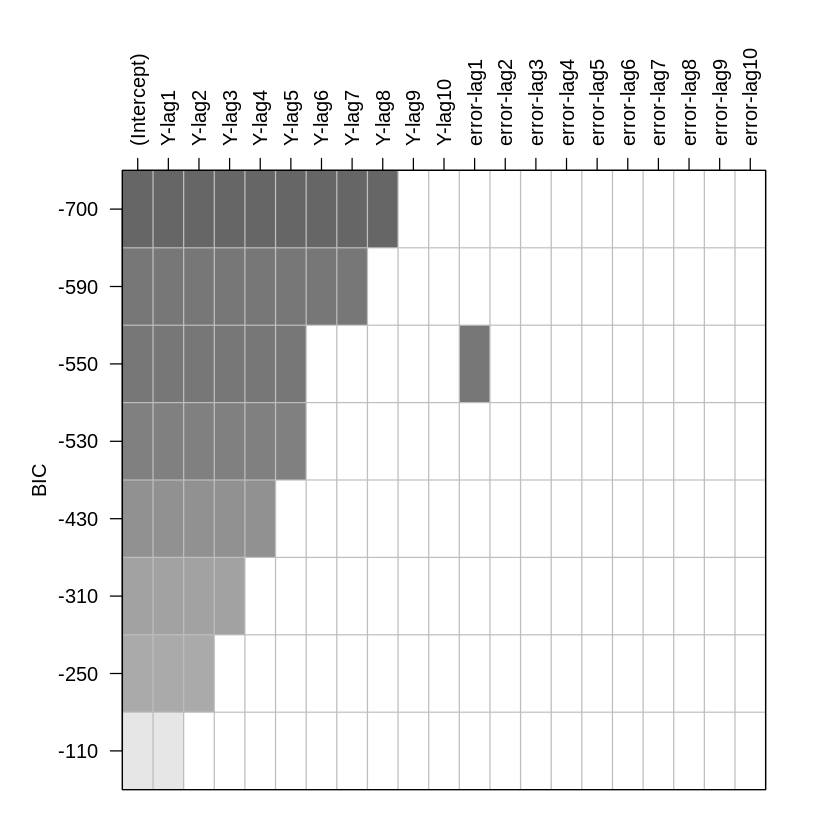

In [ ]:
library(TSA)
plot(armasubsets(airtraffictwelvthFirst, nar = 10, nma = 10))

Based on the Bayesian Information Criterion (BIC), the model that is a good fit for our time series data is AR(8) since it has the minimum BIC value of -700 which is way smaller than the second proposed model that is AR(7).

> The model AR(8) aligns well with our ACF and PACF findings and BIC so we select it to conduct the analysis.



## FIFTH STEP: Model Fitting

In [ ]:
fittedAirTraffic <- arima(airtraffictwelvthFirst, order=c(8,0,0),method='ML')
print(fittedAirTraffic)

Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
“possible convergence problem: optim gave code = 1”



Call:
arima(x = airtraffictwelvthFirst, order = c(8, 0, 0), method = "ML")

Coefficients:


Warning message in sqrt(diag(x$var.coef)):
“NaNs produced”


          ar1       ar2       ar3       ar4       ar5      ar6      ar7
      -4.5134  -10.2662  -15.3691  -16.5807  -13.2551  -7.7488  -3.0381
s.e.   0.0114       NaN       NaN       NaN       NaN      NaN      NaN
          ar8  intercept
      -0.5961      0.026
s.e.      NaN        NaN

sigma^2 estimated as 9.624:  log likelihood = -306.25,  aic = 630.5



* The variance of the white noise is: 9.624

## SIXTH STEP: Model Diagnostic

In this section we will conduct a residuals analysis, we will verify whether the model chosen is indeed a good one that captures the patterns and structure of our data correctly.

To check that we will have to make sure that the residuals are a gaussian white noise with mean 0 because:
* **Zero mean:** An average equal to zero means that the model has captured all systematic patterns, leading to unbiased predictions.
* **Independent residuals:** The absence of the auto correlation means that past errors do no influence the future predictions and therefore the model is well fitted.
* **Normality:** all relationships between the data were taken into consideration by our chosen model.


First, we plot the residuals.

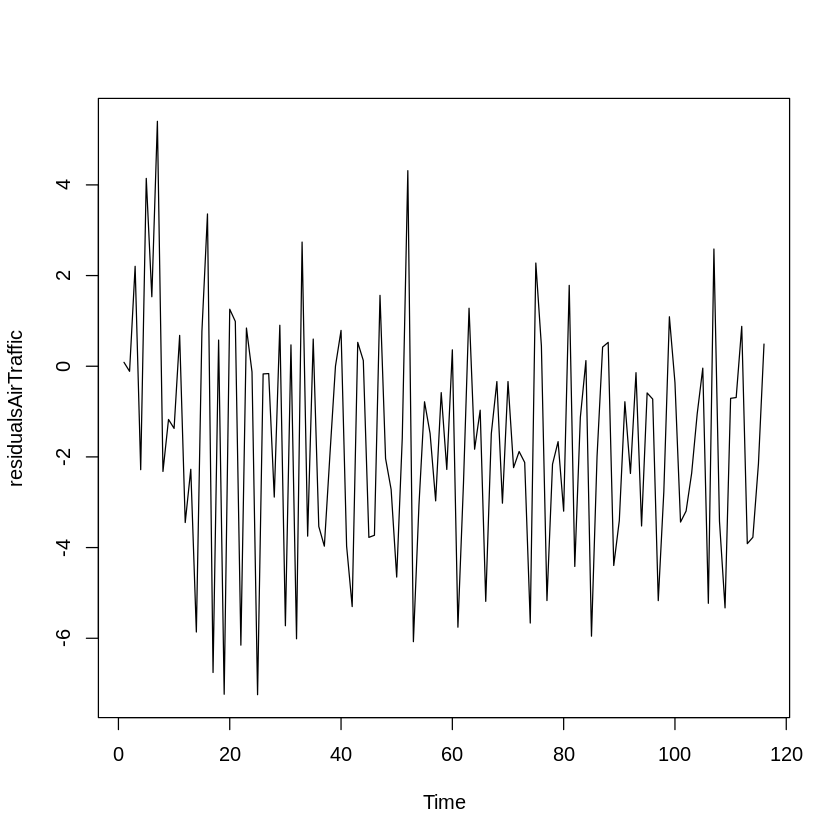

In [ ]:
residualsAirTraffic <- residuals(fittedAirTraffic)
plot(residualsAirTraffic)

From the plot of the residuals we can see that:
* The mean seems to be around 0.
* The variance appears to be stable/constant over time overall.

### **Normality and Independence plots**

### 1. Normality check

#### **Histogram of the residuals:**

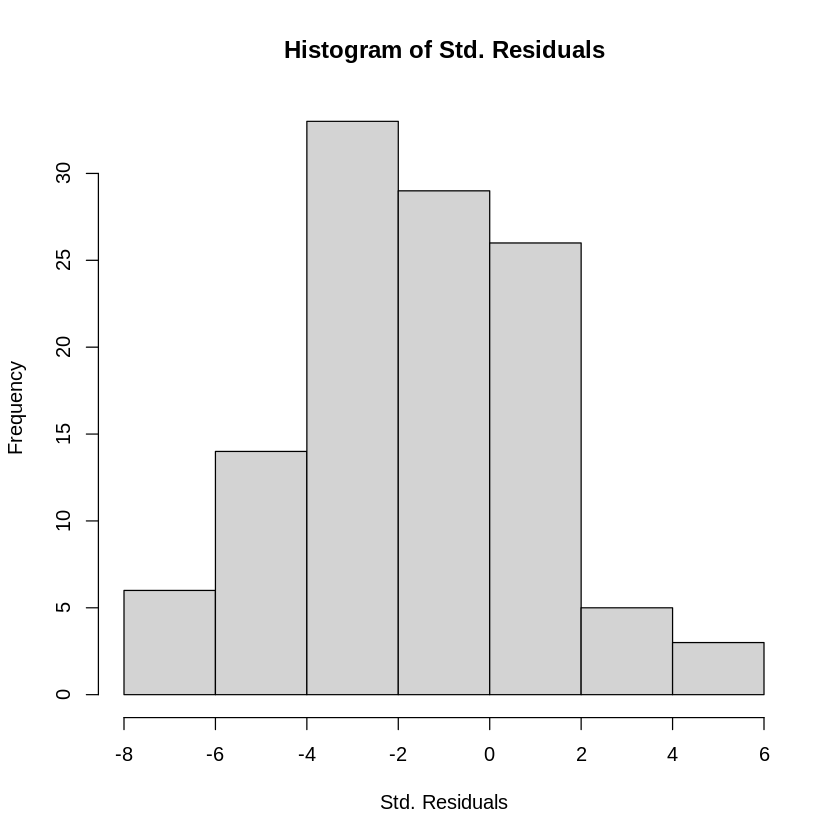

In [ ]:
hist(residualsAirTraffic, main = "Histogram of Std. Residuals", xlab = "Std. Residuals")

Despite having some fat tails at the ends, the histogram seems to be close to one of the normal distribution.


We will verify that further by drawing the QQ plot.

#### **QQ plot of the residuals:**

The QQ plot compares the theoretical quantiles of a normal distribution with the sample quantiles of the residuals. If the points form a straight line, the residuals follow a normal distribution; otherwise the residuals do not follow a normal distribution.

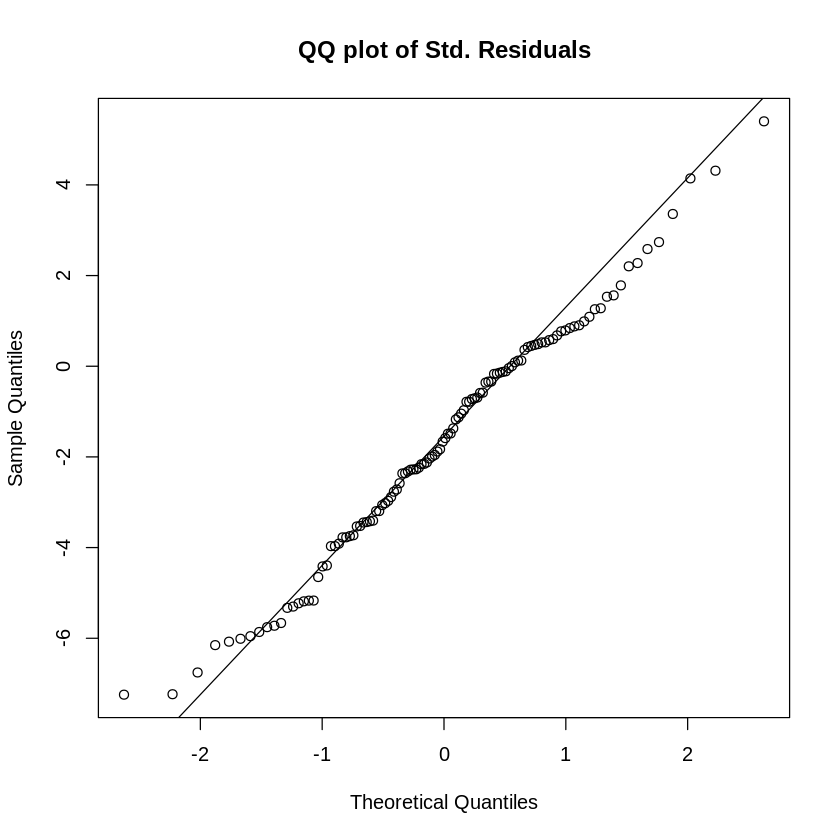

In [ ]:
qqnorm(residualsAirTraffic, main = "QQ plot of Std. Residuals")
qqline(residualsAirTraffic)

The QQ plot shows a rather straight line except for some deviations at the ends.

> From both the residuals histogram and the QQ plot we can see that the residuals probably follow a normal distribution.

We will verify whether it is true or not using the Shapiro-Wilk test for normality.

#### **Shapiro-Wilk test:**

**About Shapiro-Wilk Normality test:**
* It is a test to check whether the data follows a normal distribution or not.
* The null-hypothesis of this test is that the population is normally distributed.
  * if the p-value < 0.05 then H0 is rejected which means that our data does not follow a normal distribution.
  * if p-value > 0.05 : our data follows a normal distribution.


In [ ]:
print(shapiro.test(residualsAirTraffic))


	Shapiro-Wilk normality test

data:  residualsAirTraffic
W = 0.98769, p-value = 0.3765



The test outputs a p-value of 0.37  which is greater than the threshold 0.05 therefore we accpet the H0 that claims that the residuals follow a normal distribution.
> The residuals follow a normal distribution, all relationships in our data were accounted for by our model.

#### 2. Independence check

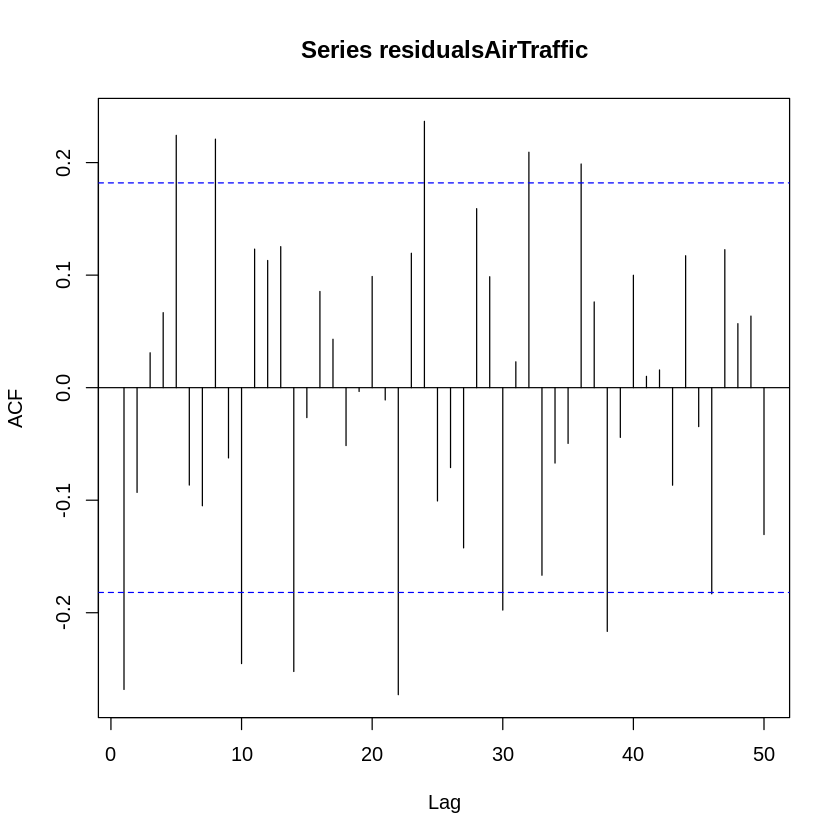

In [ ]:
acf(residualsAirTraffic, lag.max = 50)

We can see from the ACF plot of the residuals that several spikes exceed the confidence interval, indicating that the residuals exhibit autocorrelation at certain lags. This suggests that the residuals are not purely random (white noise).

We will check the independence further by applying Runs test.

#### **Runs test for independence:**

**About Runs test:**
* Runs test examines the residuals in sequence to look for patterns that would go against independence.
* It does that by calculating the number of runs above and below the median of the residuals which is normally around 0.
* The null-hypothesis of this test is that the residuals are independent of each other.
  * if the p-value < 0.05 then H0 is rejected which means that our residuals are dependent .
  * if p-value > 0.05 : residuals are independent.

In [ ]:
print(runs(residualsAirTraffic))

$pvalue
[1] 0.771

$observed.runs
[1] 51

$expected.runs
[1] 49.06897

$n1
[1] 82

$n2
[1] 34

$k
[1] 0



The runs test produced a p-value of 0.771, which is greater than the significance threshold of 0.05. This means that we fail to reject the null hypothesis (H₀), which states that the residuals are independent.

> The residuals appear to be randomly distributed and do not show any systematic patterns over time.

#### 3. Autocorrelation check

#### **Ljung-box test**


We will now apply Ljung-Box test to see if the ARMA(8,0) model is indeed an appropriate one in a way that the residuals are not correlated.

**About Ljung-box test:**
* It checks whether the residuals are white noise (i.e., uncorrelated over time) or not.
* The null hypothesis is that the residuals have no autocorrelation (they are white noise).
  * if p-value < 0.05 then we reject the null hypothesis, therefore our residuals are correlated and not white noise.
  * if p-value > 0.05 we accept H0 and we can say that our residuals are indeed white noise.

In [ ]:
print(Box.test(residualsAirTraffic, lag = 20, type = "Ljung-Box"))


	Box-Ljung test

data:  residualsAirTraffic
X-squared = 50.604, df = 20, p-value = 0.0001814



Our test outputs a p-value of 0.0001814, which is smaller than 0.05 the significance level. Therefore, we reject the null hypothesis and conclude that the residuals are not white noise, as the Ljung-Box test detected autocorrelation at different lags.

> From our diagnostic, we found that the residuals are normally distributed and independent in terms of sign changes, meaning there is no clear systematic pattern. However, the Ljung-Box test indicates autocorrelation, suggesting that past residuals influence future ones which means that **they are not white noise.**

Therefore we can say that the AR(8) model is not the best fit for our air traffic data and that a different model may provide a better representation.

## SEVENTH STEP: Forecasting

Even though our model did not fit our data perfectly, we will try and predict the number of passengers for the last 14 months of our data check it with the test data.

In [ ]:
fittedModel <- Arima(airtrafficTrain, order = c(8, 0, 0))

forecastedValues <- forecast(fittedModel, h = 15)


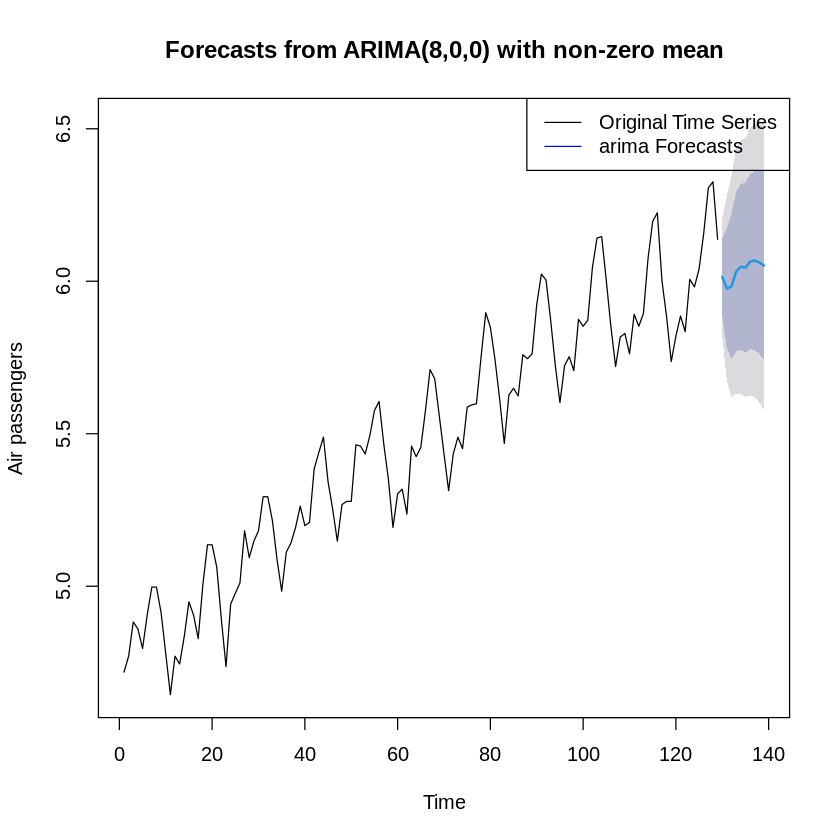

In [ ]:
# plotting the original time series and the forecasts
plot(forecastedValues,
     type ='l', xlab='Time', ylab ='Air passengers')
legend("topright", legend=c('Original Time Series', 'arima Forecasts'), col=c('black', 'blue'), lty=1)

We can see that our forecasted values do not truly match our data which is due to our model ARIMA(8,0,0) not perfectly fitting it.
Choosing a better fit would have yielded better results.

## **Summary**

The analysis of the Air Passengers dataset was aimed at finding trends, seasonality, and forecasting future values based on historical data from 1949 to 1960. The dataset was first preprocessed by converting the date column to the appropriate format and then plotting the time series to check for patterns. It had an upward trend with seasonal variations, so some stabilization and differencing techniques were applied to help reach stationarity.
After that to find a suitable model, checks for stationarity were used like the ADF test and some tools like the BIC alongside the ACF and the PACF plots were used to find candidate models.
A model was chosen and a diagnostic was performed to determine whether it is truly suitable and a good fit to the air passengers data or not.
For the diagnostic, a residuals analysis was conducted, even though the residuals were normal and independent according to runs test meaning all patterns were accounted for by the model, Ljung box test showed an existing auto correlation between the residuals which means that they are not white noise and therefore our model is not the perfect fit for our data.
For forecasting, our model AR(8) was used to try and predict, it gave some predictions whithin the confidence interval yet not very accurate compared to the actual data.

The main challenges in this study were selecting an optimal forecasting model, as traditional indicators like ACF, PACF, and BIC were not always sufficient for precise model selection. This required additional fine-tuning and experimentation to achieve the best performance possible.